## Dataset

Seleccionamos algunos atributos del dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt

world = gpd.read_file('ne_50m_admin_0_countries.geojson')
south_america = world[world.continent == 'South America']
chile = world[world.admin == 'Chile']

stations = pd.read_csv('chile-climate - stations.tsv', low_memory=True, sep='\t')
stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.lon, stations.lat)
)
measures = pd.read_pickle('clima_chile.pkl.xz')
measures.drop(['name','altitude','lat','lon'], axis=1, inplace=True)

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [2]:
data = stations.merge(measures, on='station_id')
data.head()

,station_id,name,altitude,lat,lon,country,geometry,precipitations,avg_temperature,min_temperature,max_temperature,date
0,330020,Quinta Normal Santiago,527,-33.445,-70.6828,Chile,POINT (-70.68280029 -33.44499969),0.000000,NaN,11.368,26.987000,1958-12-01
1,330020,Quinta Normal Santiago,527,-33.445,-70.6828,Chile,POINT (-70.68280029 -33.44499969),0.000000,NaN,12.571,27.938999,1959-01-01
2,330020,Quinta Normal Santiago,527,-33.445,-70.6828,Chile,POINT (-70.68280029 -33.44499969),0.000000,NaN,13.611,28.568001,1959-02-01
3,330020,Quinta Normal Santiago,527,-33.445,-70.6828,Chile,POINT (-70.68280029 -33.44499969),18.200001,NaN,11.623,26.497000,1959-03-01
4,330020,Quinta Normal Santiago,527,-33.445,-70.6828,Chile,POINT (-70.68280029 -33.44499969),59.500000,NaN,8.810,18.860001,1959-04-01


## Distribucion Geográfica

Son estaciones en sud-america, filtramos por estaciones unicas.


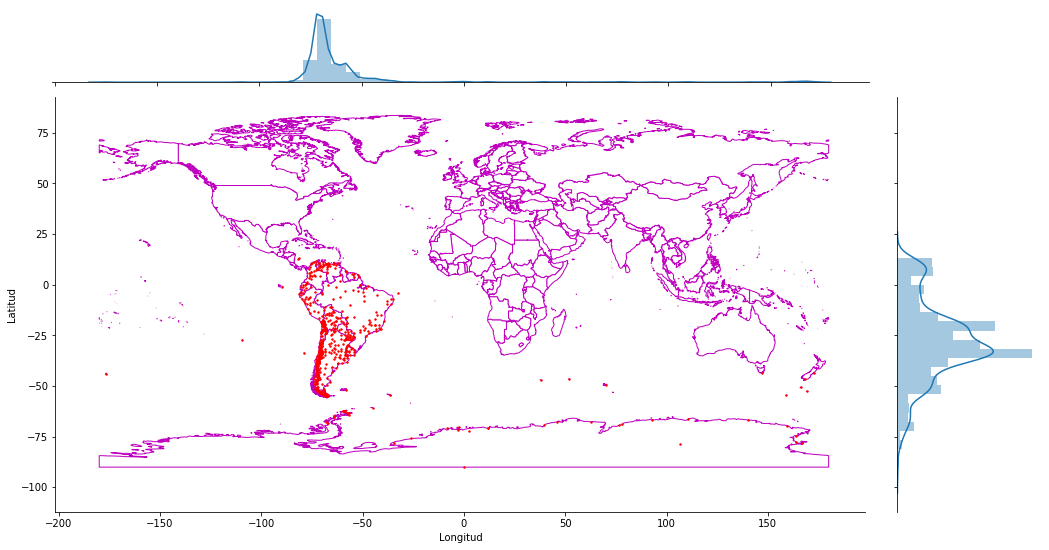

In [3]:
def plot_coord_distrib(wmap, points, kw_map={}, kw_points={}):
    g = sns.JointGrid(x="lon", y="lat", data=points)

    def map_joint(x, y, *args, **kwargs):
        wmap.plot(ax=g.ax_joint, color='w', edgecolor='m', **kw_map)
        points.plot(ax=g.ax_joint, color='r', **kw_points)

    g = g.plot(map_joint, sns.distplot)
    g.set_axis_labels("Longitud", "Latitud")
    return g

g = plot_coord_distrib(world, stations, kw_points={'markersize':2})
g.fig.set_figwidth(16)
g.fig.set_figheight(8)
g.savefig("world_stations.png", dpi=300)

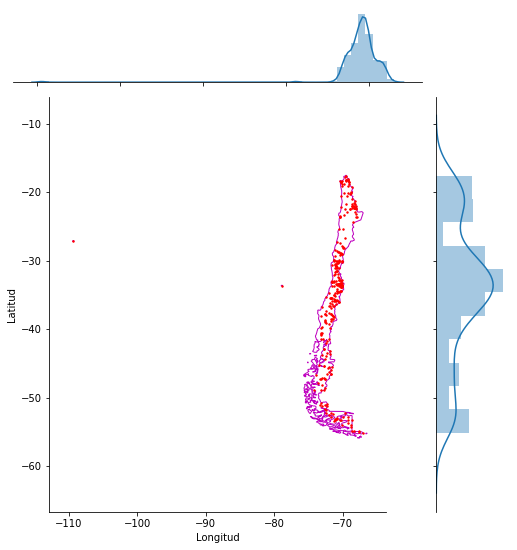

In [4]:
g = plot_coord_distrib(chile, stations[stations.country == 'Chile'], kw_points= {'markersize':2})
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
g.savefig("chile_stations.png", dpi=300)

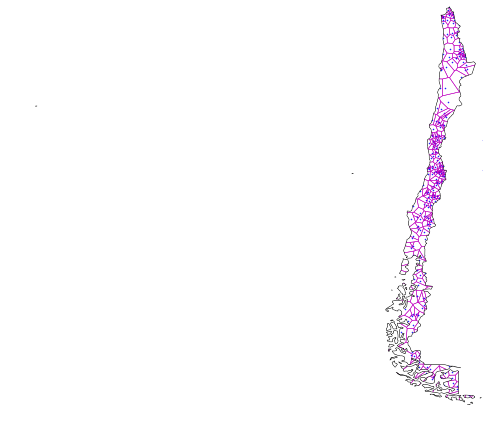

In [5]:
ax = gplt.voronoi(
    stations[stations.country == 'Chile'],
    linewidth=0.5,
    edgecolor='m',
    clip=chile.geometry,
)

g = gplt.polyplot(chile, ax=ax)
g = stations.plot(ax=g, color='b', markersize=0.25)

g.figure.set_figwidth(8)
g.figure.set_figheight(8)
g.figure.savefig("chile_voronoi.png", dpi=300)

In [45]:

from shapely.geometry import Polygon
# Find a bbox that only encloses continental chile
#for f in chile.geometry.values[0]:
#    print(f.centroid)

# Handmade bbox:
lt0, ln0, lt1, ln1= -78, -20, -60, -60
bbox = gpd.GeoSeries([Polygon([(lt0, ln0),(lt0, ln1),(lt1, ln1),(lt1, ln0)])])
bbox.crs = chile.crs
fchile = chile.copy()
fchile['geometry'] = chile['geometry'].difference(bbox)

print(type(fchile))
#ax = sns.boxplot(x=chi["total_bill"])

<class 'geopandas.geodataframe.GeoDataFrame'>


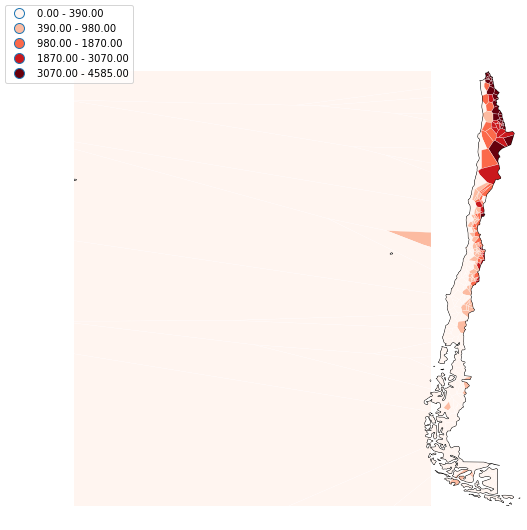

In [46]:
fstat = stations[stations.country == 'Chile']
fstat = fstat[(fstat.name != 'Mataveri Isla De Pascua Ap.') & (fstat.name != 'Juan Fernandez Estacion Meteorologica')]

ax = gplt.voronoi(
    fstat,
    hue='altitude',
    cmap='Reds',
    scheme='fisher_jenks',
    clip=chile.geometry,
    legend=True,
    legend_kwargs={'loc': 'upper left'},
    linewidth=0.25,
    edgecolor='w'
)

g = gplt.polyplot(fchile, ax=ax)

g.figure.set_figwidth(8)
g.figure.set_figheight(8)
g.figure.savefig("chile_voronoi_altitude.png", dpi=300)

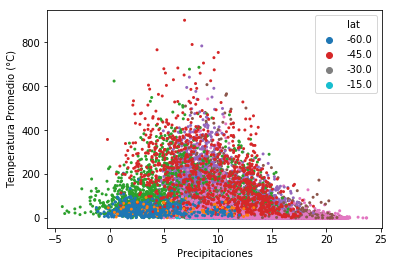

In [68]:
fdata = data[data.country == 'Chile']
fdata = fdata[(fdata.name != 'Mataveri Isla De Pascua Ap.') & (fdata.name != 'Juan Fernandez Estacion Meteorologica')]

g = sns.scatterplot('avg_temperature','precipitations', data=fdata, palette="tab10", linewidth=0, marker='.', hue='lat')
g.set(xlabel='Precipitaciones', ylabel='Temperatura Promedio (°C)')
g.figure.savefig("whittaker.png", dpi=300)



In [66]:
fdata.describe()

,altitude,lat,lon,precipitations,avg_temperature,min_temperature,max_temperature
count,16549.000000,16549.000000,16549.000000,16468.000000,11167.000000,15947.000000,15956.000000
mean,276.107257,-41.144801,-71.692359,86.986023,10.580860,5.516946,16.365650
std,436.524478,7.162219,1.316331,104.916641,4.705057,3.487006,6.307015
min,10.000000,-54.931702,-73.097801,0.000000,-4.363000,-8.561000,-0.884000
25%,38.000000,-45.593899,-72.663902,13.800000,7.486000,3.181000,12.042000
50%,151.000000,-41.435001,-71.852501,48.000000,10.445000,5.643000,16.014500
75%,310.000000,-36.587200,-70.845001,123.400002,13.798500,7.977000,20.632750
max,2293.000000,-22.498899,-67.615601,1126.599976,23.716000,15.839000,33.299999


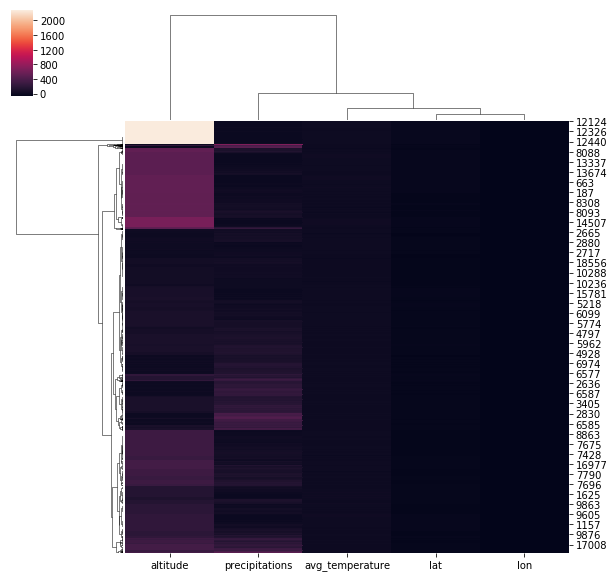

In [60]:
g = sns.clustermap(fdata[['altitude','lat','lon','precipitations','avg_temperature']].dropna())

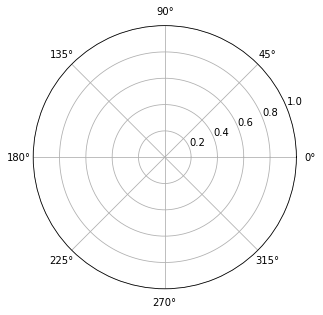

In [69]:
g = sns.FacetGrid(
    fdata,
    #col="speed",
    #hue="speed",
    subplot_kws=dict(projection='polar'),
    height=4.5,
    sharex=False,
    sharey=False,
    despine=False
)

# Draw a scatterplot onto each axes in the grid
#g.map(sns.scatterplot, "theta", "r")